In [ ]:
import pandas as pd
import os
import pydpmd as dp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LogNorm
from scipy.optimize import minimize

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def get_relaxation_time_fit(f, t, tau_guess):
    # fit an exponential to f(t) using tau_guess as a starting point
    def obj(tau):
        return np.sum((f - np.exp(-t / tau)) ** 2)
    tau = minimize(obj, tau_guess).x[0]
    return tau

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

In [136]:
compression_root = '/Users/marshallmccraw/Projects/yale/data/f-25/12-01-25/grace-data/11-11-25/small'

df = {
    'nv': [],
    'mu': [],
    'phi': [],
    'phi_eff': [],
    'pressure': [],
    'temp': [],
    'msd': [],
    'msad': [],
    'isf_small': [],
    'isf_large': [],
    'angular_isf_small': [],
    'angular_isf_large': [],
    't': [],
    'g_small': [],
    'g_large': [],
    'r': [],
    'r0_small': [],
    'r0_large': [],
    'tau_small': [],
    'tau_large': [],
    'atau_small': [],
    'atau_large': [],
    # 'tau_small_fit': [],
    # 'tau_large_fit': [],
    # 'atau_small_fit': [],
    # 'atau_large_fit': [],
    'D': [],
    'aD': [],
    'n_obs': [],
    'an_obs': [],
    'DR2': [],
    'aDR2': [],
}

for root in tqdm(os.listdir(compression_root)):
    if '.DS' in root:
        continue
    for fname in os.listdir(os.path.join(compression_root, root)):
        if 'dynamics' not in fname:
            continue
        if '.DS' in fname:
            continue
        path = os.path.join(compression_root, root, fname)

        data = dp.data.load(path, location=['final', 'init'])
        data.calculate_mu_eff()
        df['nv'].extend(data.n_vertices_per_particle[data.system_offset[:-1]] - 1)
        df['mu'].extend(data.mu_eff[data.system_offset[:-1]])
        df['phi'].extend(data.packing_fraction)
        df['pressure'].extend(data.final.mean_pressure)
        df['temp'].extend(data.final.mean_temperature)
        df['msd'].extend(data.final.msd[..., 0].T)
        df['msad'].extend(data.final.msd[..., 1].T)
        df['isf_small'].extend(data.final.isf[:, 0, :].T)
        df['isf_large'].extend(data.final.isf[:, 1, :].T)
        df['angular_isf_small'].extend(data.final.angular_isf[:, 0, :].T)
        df['angular_isf_large'].extend(data.final.angular_isf[:, 1, :].T)
        df['t'].extend([data.final.t for _ in range(data.n_systems())])
        df['g_small'].extend(data.final.g[:, 0])
        df['g_large'].extend(data.final.g[:, 1])
        df['r'].extend([data.final.r for _ in range(data.n_systems())])

        df['phi_eff'].extend(np.add.reduceat(np.pi * data.rad ** 2, data.system_offset[:-1]) / np.prod(data.box_size, axis=-1))

        for i in range(data.n_systems()):
            g_small = data.final.g[i, 0]
            g_large = data.final.g[i, 1]
            msd = data.final.msd[:, i, 0]
            msad = data.final.msd[:, i, 1]
            isf_small = data.final.isf[:, 0, i]
            isf_large = data.final.isf[:, 1, i]
            angular_isf_small = data.final.angular_isf[:, 0, i]
            angular_isf_large = data.final.angular_isf[:, 1, i]
            t = data.final.t
            r = data.final.r

            D, n_obs, DR2 = fit_log(t, msd, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
            aD, an_obs, aDR2 = fit_log(t, msad, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
            df['D'].append(D)
            df['n_obs'].append(n_obs)
            df['DR2'].append(DR2)
            df['aD'].append(aD)
            df['an_obs'].append(an_obs)
            df['aDR2'].append(aDR2)
            
            tau_small = get_relaxation_time(isf_small, t)
            tau_large = get_relaxation_time(isf_large, t)
            df['tau_small'].append(tau_small)
            df['tau_large'].append(tau_large)

            atau_small = get_relaxation_time(angular_isf_small, t)
            atau_large = get_relaxation_time(angular_isf_large, t)
            df['atau_small'].append(atau_small)
            df['atau_large'].append(atau_large)

            r0_small = get_peak_location(r, g_small)
            r0_large = get_peak_location(r, g_large)
            df['r0_small'].append(r0_small)
            df['r0_large'].append(r0_large)

            # tau_small_fit = get_relaxation_time_fit(isf_small, t, tau_small)
            # tau_large_fit = get_relaxation_time_fit(isf_large, t, tau_large)
            # df['tau_small_fit'].append(tau_small_fit)
            # df['tau_large_fit'].append(tau_large_fit)

            # atau_small_fit = get_relaxation_time_fit(angular_isf_small, t, atau_small)
            # atau_large_fit = get_relaxation_time_fit(angular_isf_large, t, atau_large)
            # df['atau_small_fit'].append(atau_small_fit)
            # df['atau_large_fit'].append(atau_large_fit)
            

df = pd.DataFrame(df)

100%|██████████| 6/6 [01:19<00:00, 13.22s/it]


In [24]:
df[['nv', 'mu', 'phi', 'pressure', 'temp']].to_csv('large-data.csv', index=False)

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/2495405107.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.pressure, s=1, c=cmap(mu_norm(mu)))


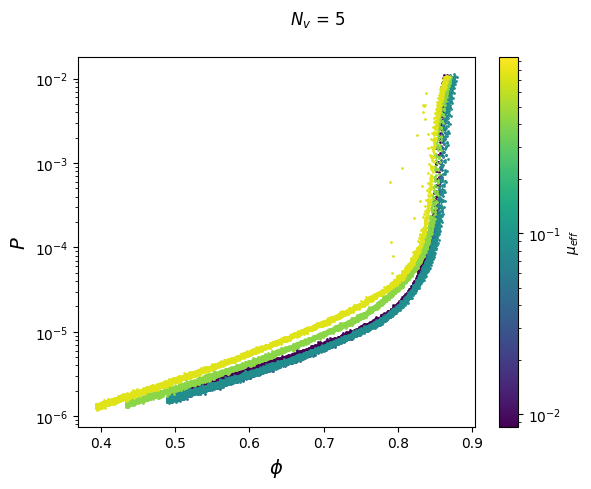

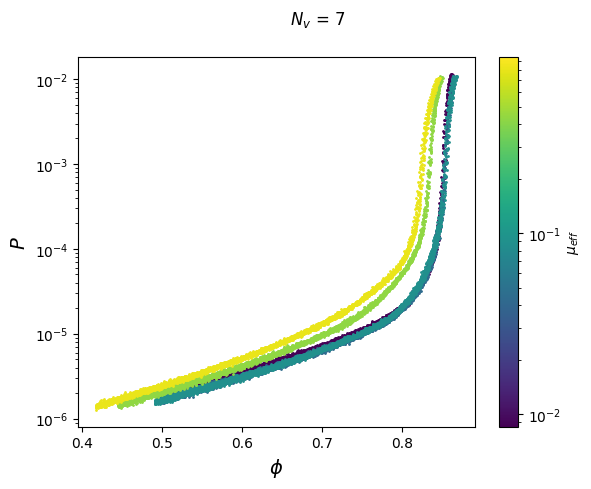

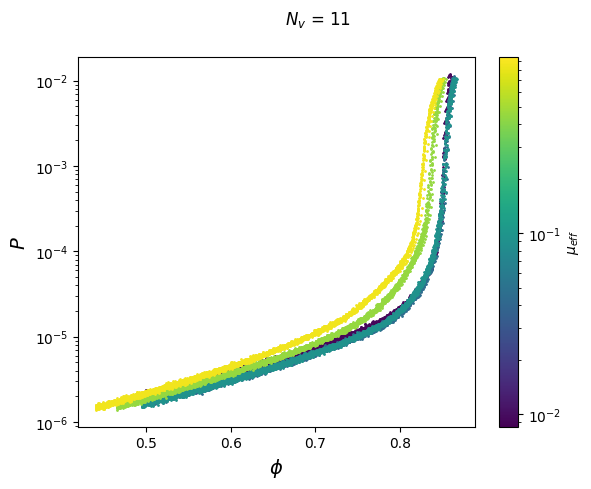

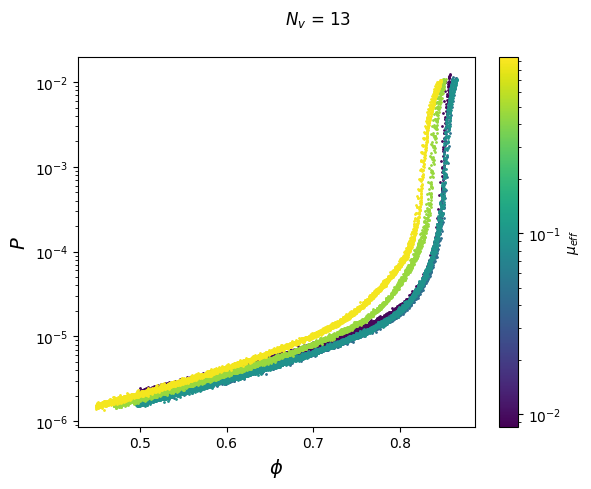

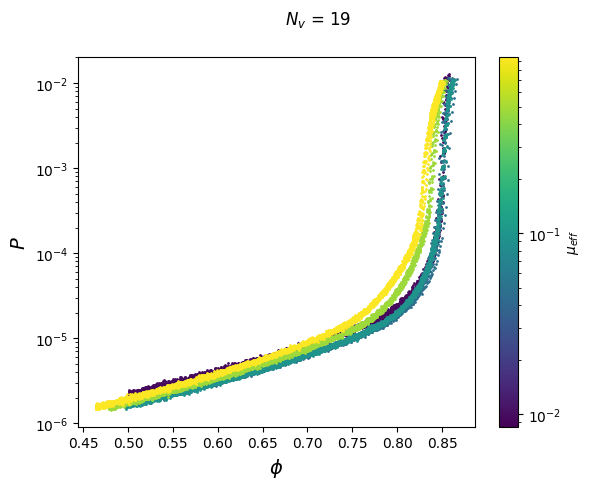

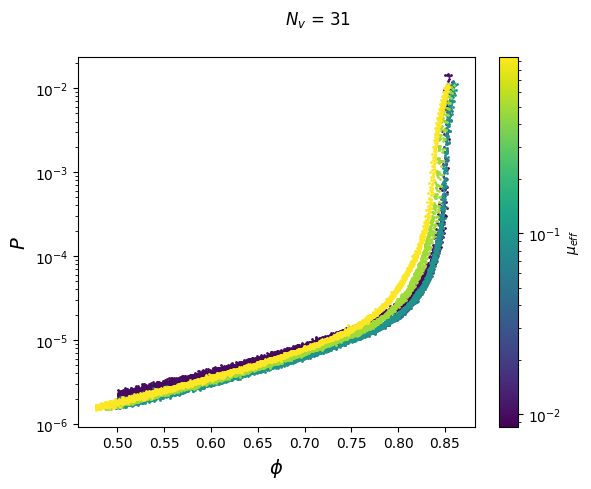

In [56]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.phi, _df.pressure, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.xlabel(r'$\phi$', fontsize=14)
    plt.ylabel(r'$P$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv)}')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(df.mu.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/pressure/NV-{nv}.png', dpi=600)
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/2014819641.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = _df.groupby(pd.cut(_df.phi, bins))['pressure'].mean()
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/2014819641.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[1:], y, s=1, c=cmap(mu_norm(mu)))


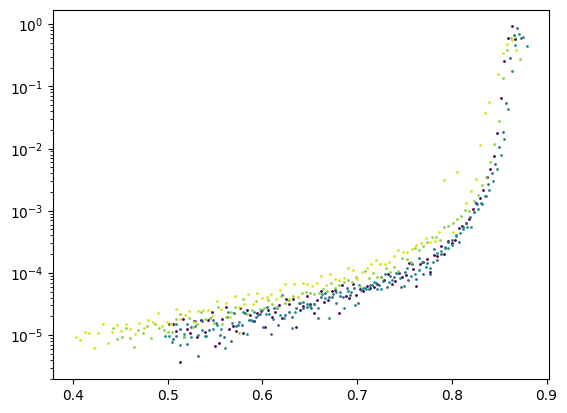

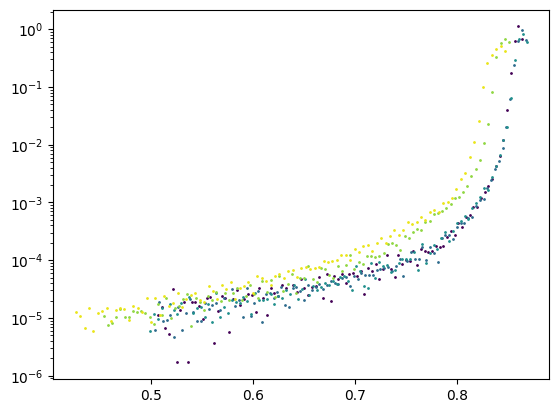

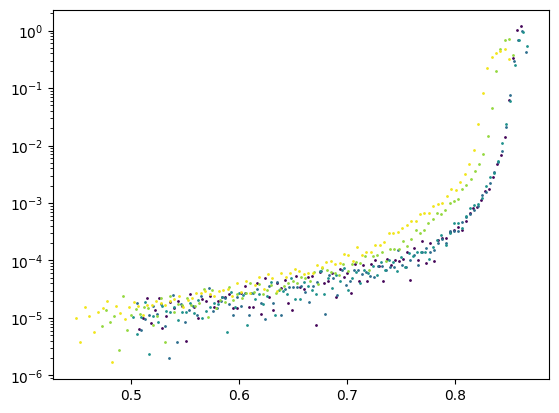

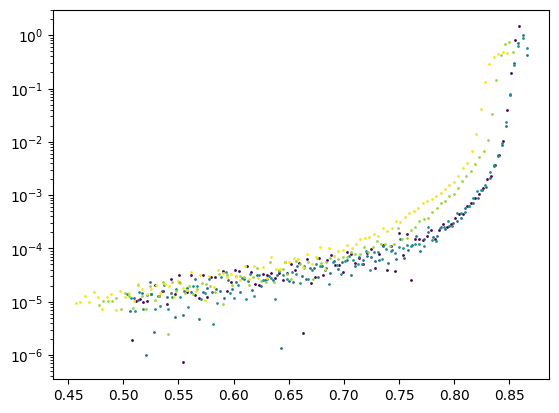

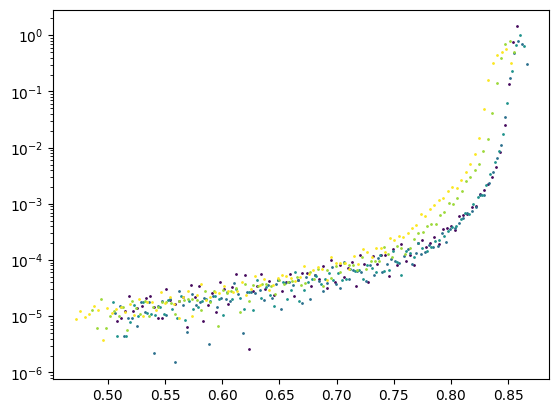

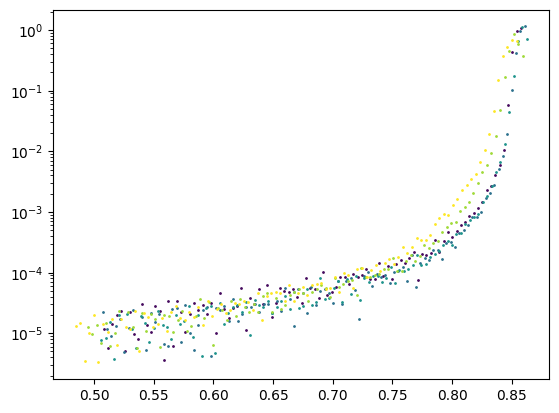

In [57]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        x = _df.phi.values
        y = _df.pressure.values
        bins = np.linspace(_df.phi.min(), _df.phi.max(), 100)
        binned = _df.groupby(pd.cut(_df.phi, bins))['pressure'].mean()

        # plt.scatter(x[:-1], np.diff(y) / np.diff(x), s=1, c=cmap(mu_norm(mu)))

        x = bins[1:]
        y = np.diff(binned) / np.diff(x)
        
        plt.scatter(x[1:], y, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.show()



/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/3708203371.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.tau_small, s=1, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/3708203371.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.atau_small, s=1, c=cmap(mu_norm(mu)))


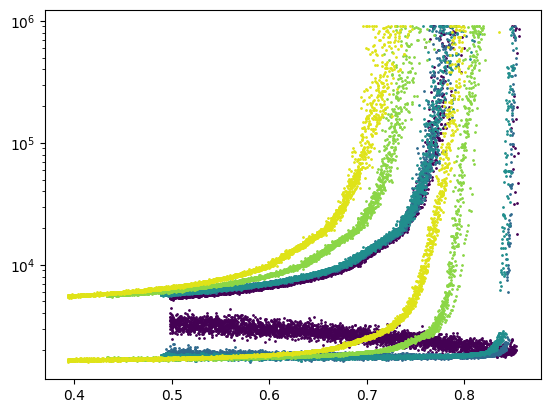

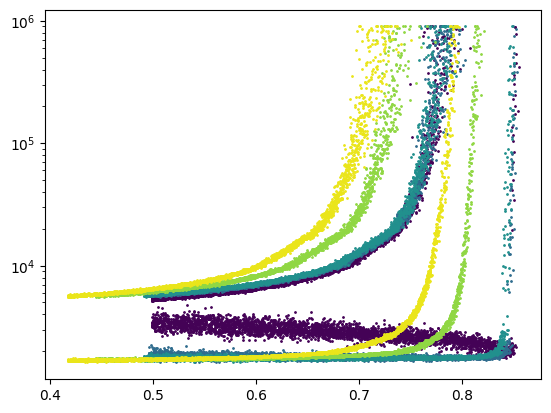

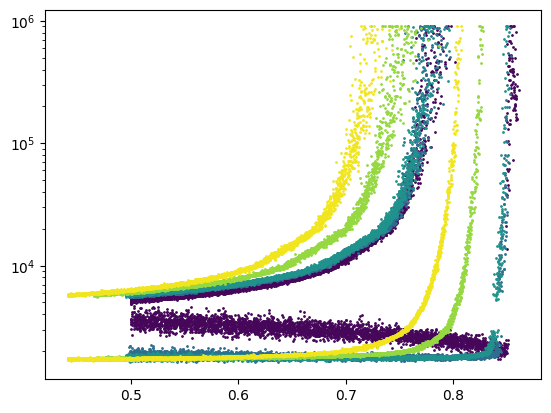

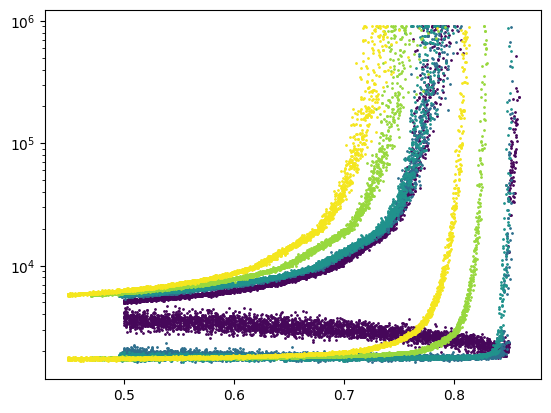

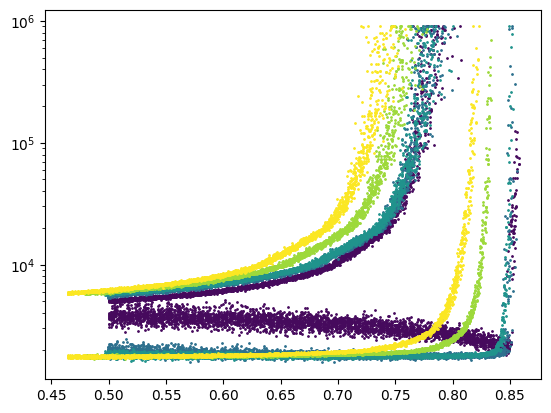

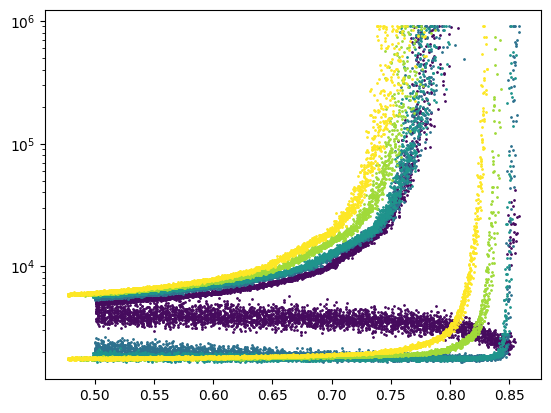

In [59]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.phi, _df.tau_small, s=1, c=cmap(mu_norm(mu)))
        plt.scatter(_df.phi, _df.atau_small, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/1838926795.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.D, s=1, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/1838926795.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.aD, s=1, c=cmap(mu_norm(mu)))


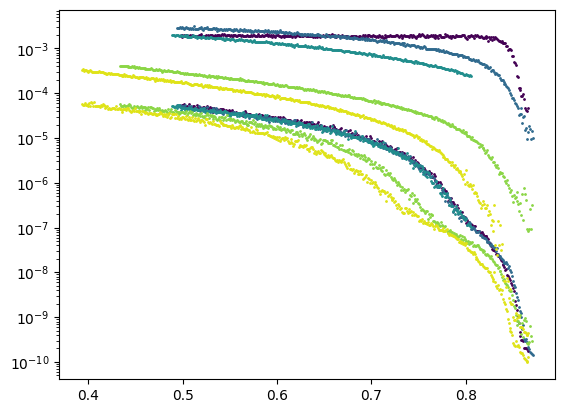

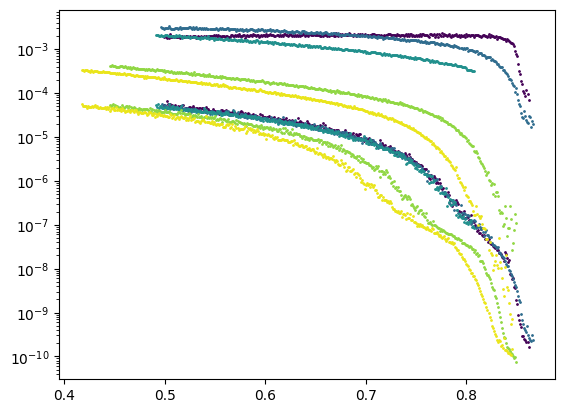

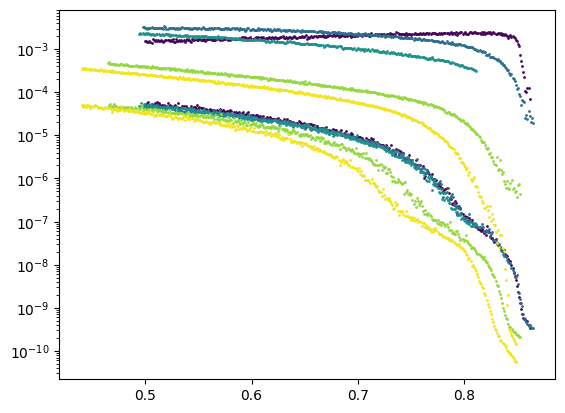

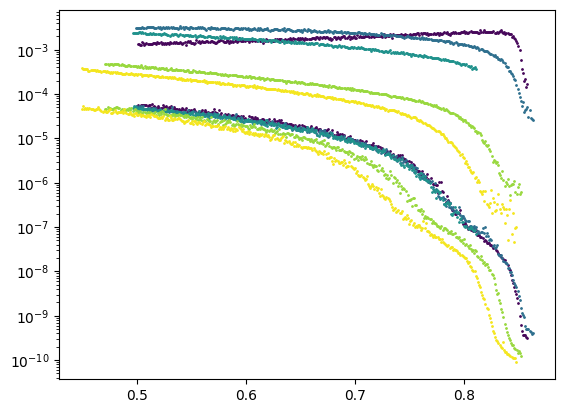

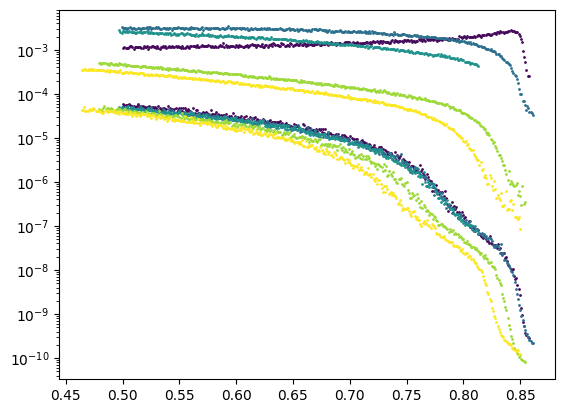

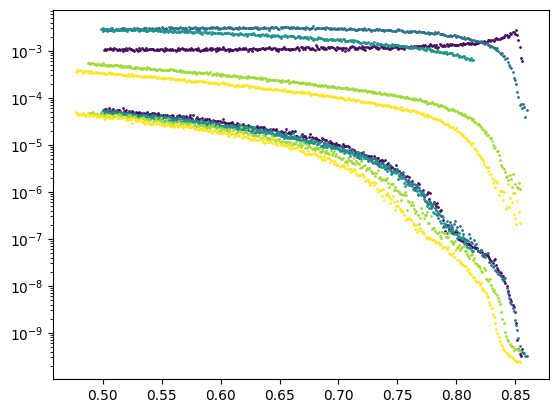

In [ ]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.phi, _df.D, s=1, c=cmap(mu_norm(mu)))
        plt.scatter(_df.phi, _df.aD, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/327013735.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tau_small_binned = _df.groupby(pd.cut(_df.phi, phi_bins))['tau_small'].mean()
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/327013735.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atau_small_binned = _df.groupby(pd.cut(_df.phi, phi_bins))['atau_small'].mean()
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/327013735.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pa

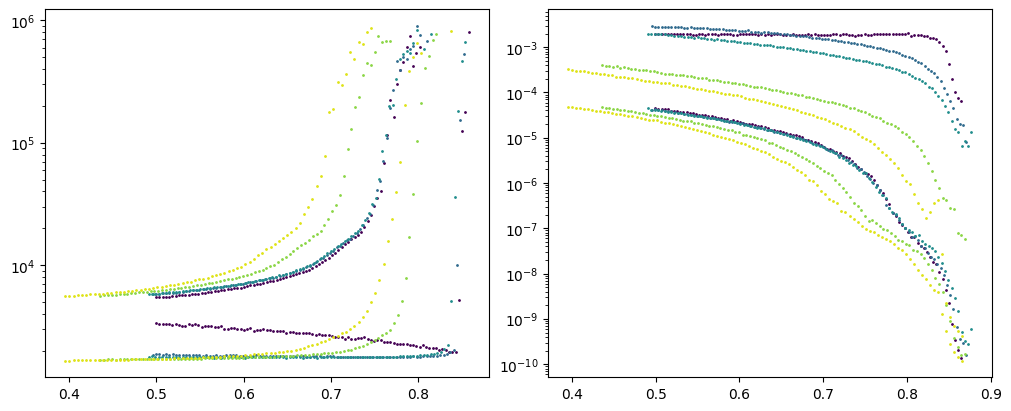

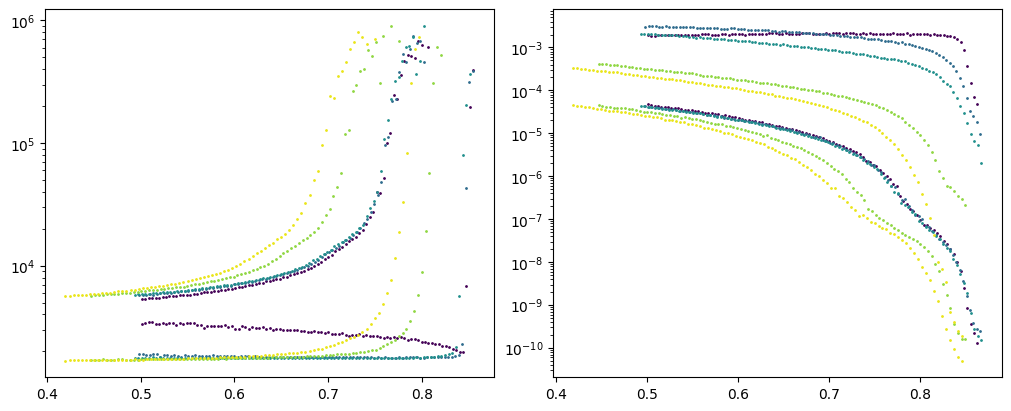

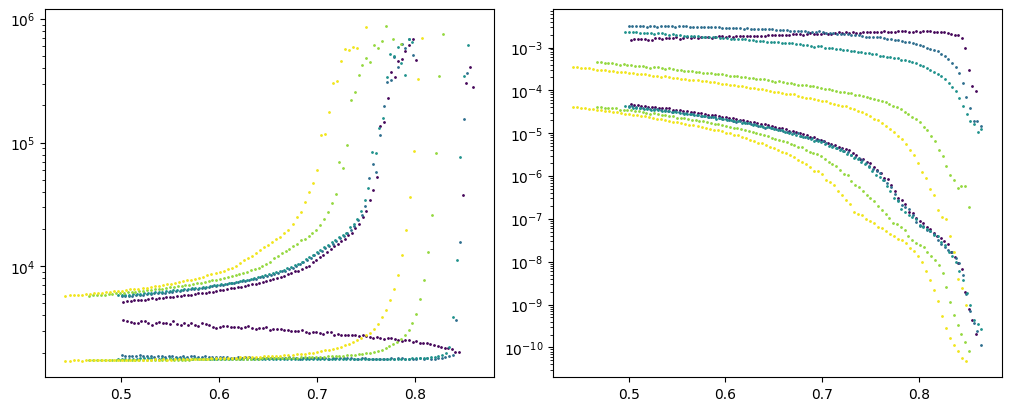

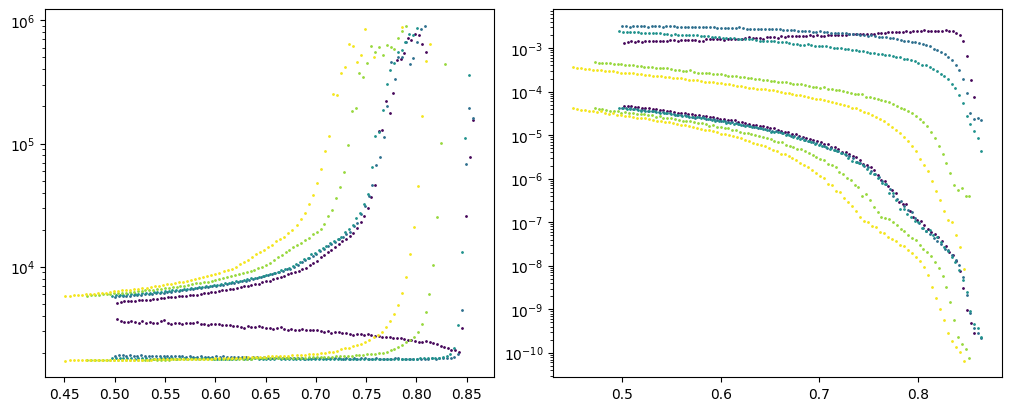

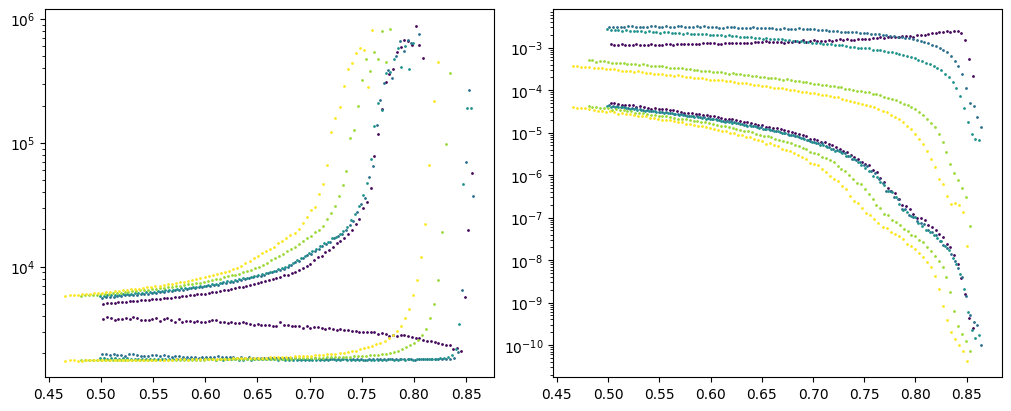

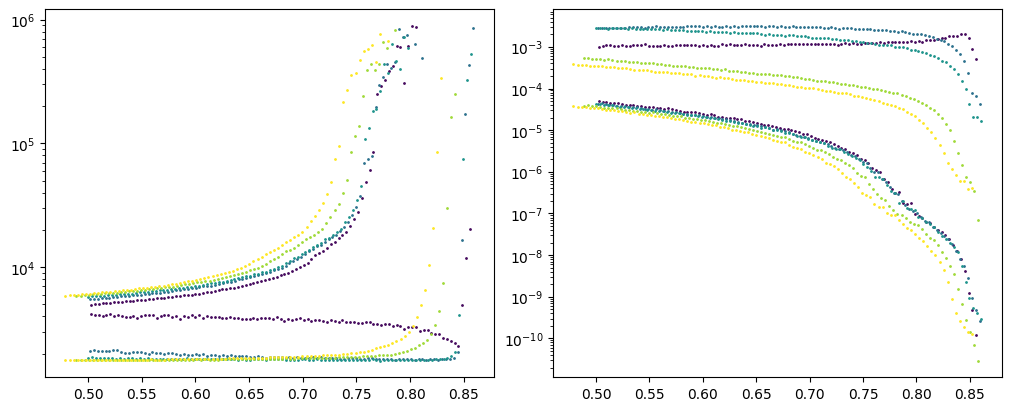

In [69]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]

        phi_bins = np.linspace(_df.phi.min(), _df.phi.max(), 100)
        tau_small_binned = _df.groupby(pd.cut(_df.phi, phi_bins))['tau_small'].mean()
        atau_small_binned = _df.groupby(pd.cut(_df.phi, phi_bins))['atau_small'].mean()
        D_binned = _df.groupby(pd.cut(_df.phi, phi_bins))['D'].mean()
        aD_binned = _df.groupby(pd.cut(_df.phi, phi_bins))['aD'].mean()

        phi = (phi_bins[1:] + phi_bins[:-1]) / 2


        ax[0].scatter(phi, tau_small_binned, s=1, c=cmap(mu_norm(mu)))
        ax[0].scatter(phi, atau_small_binned, s=1, c=cmap(mu_norm(mu)))
        ax[1].scatter(phi, D_binned, s=1, c=cmap(mu_norm(mu)))
        ax[1].scatter(phi, aD_binned, s=1, c=cmap(mu_norm(mu)))
    for a in ax:
        a.set_yscale('log')
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/371165368.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(_df.phi[mask], _df.tau_small[mask], s=5, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/371165368.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(_df.phi[mask], _df.D[mask], s=5, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd

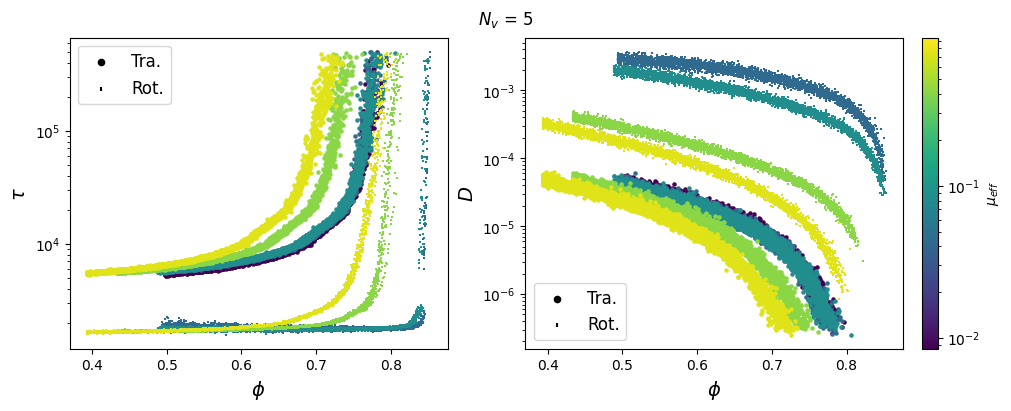

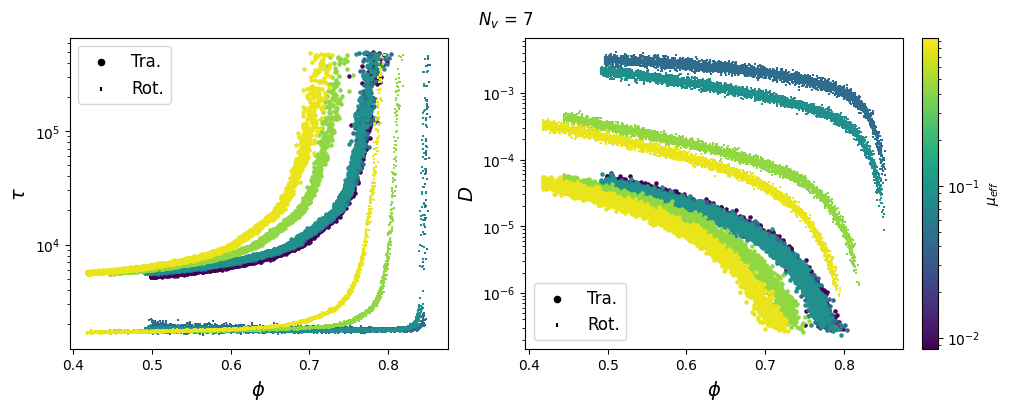

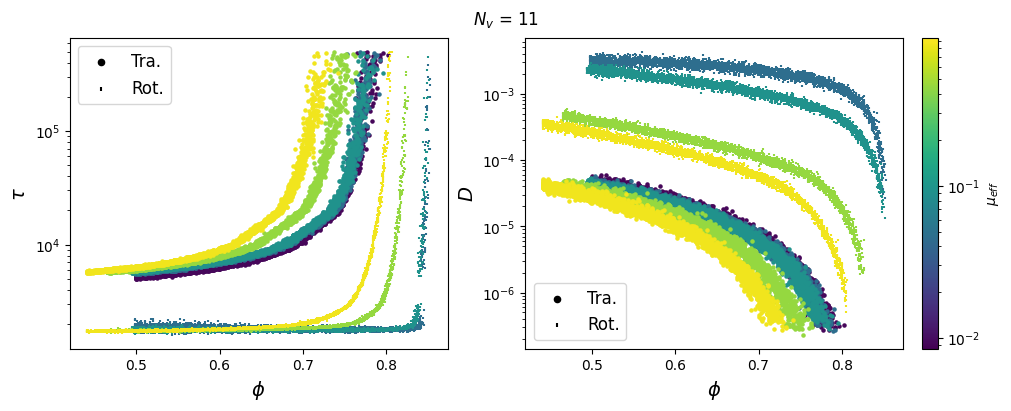

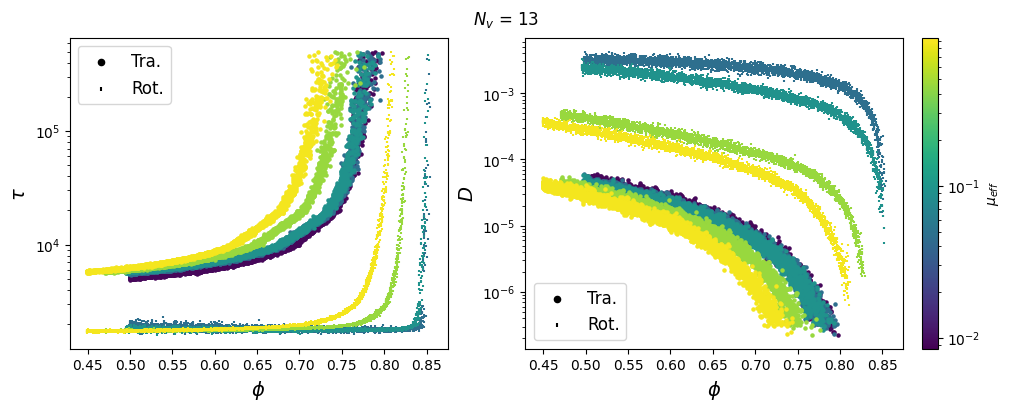

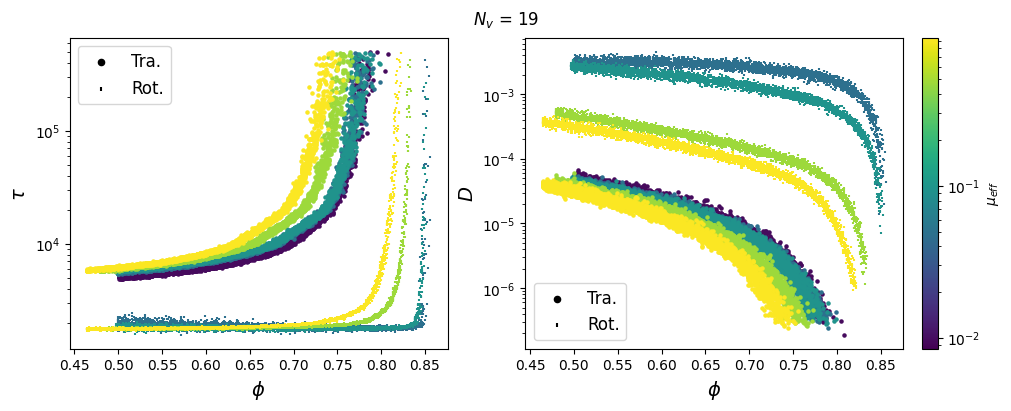

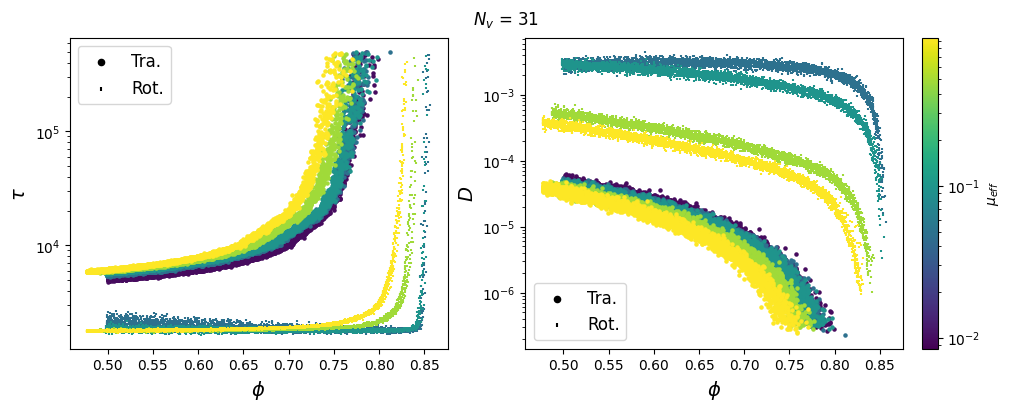

In [127]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]

        mask = ~np.isnan(_df.tau_small) & (_df.tau_small < 5e5)
        amask = ~np.isnan(_df.atau_small) & (_df.atau_small < 5e5)

        ax[0].scatter(_df.phi[mask], _df.tau_small[mask], s=5, c=cmap(mu_norm(mu)))
        ax[1].scatter(_df.phi[mask], _df.D[mask], s=5, c=cmap(mu_norm(mu)))

        if mu > 1e-2:
            ax[0].scatter(_df.phi[amask], _df.atau_small[amask], s=1, c=cmap(mu_norm(mu)), marker='|')
            ax[1].scatter(_df.phi[amask], _df.aD[amask], s=1, c=cmap(mu_norm(mu)), marker='|')
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
        a.scatter([], [], c='k', marker='o', s=20, label='Tra.')
        a.scatter([], [], c='k', marker='|', s=10, label='Rot.')
        a.legend(fontsize=12)
    ax[0].set_ylabel(r'$\tau$', fontsize=14)
    ax[1].set_ylabel(r'$D$', fontsize=14)

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(df.mu.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.suptitle(fr'$N_v$ = {int(nv)}')
    plt.savefig(f'figures/tau-D/NV-{nv}.png', dpi=600)

    plt.show()

In [ ]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]

        mask = ~np.isnan(_df.tau_small) & (_df.tau_small < 5e5)
        amask = ~np.isnan(_df.atau_small) & (_df.atau_small < 5e5)

        ax[0].scatter(_df.phi_eff[mask], _df.tau_small[mask], s=5, c=cmap(mu_norm(mu)))
        ax[1].scatter(_df.phi_eff[mask], _df.D[mask], s=5, c=cmap(mu_norm(mu)))

        if mu > 1e-2:
            ax[0].scatter(_df.phi_eff[amask], _df.atau_small[amask], s=1, c=cmap(mu_norm(mu)), marker='|')
            ax[1].scatter(_df.phi_eff[amask], _df.aD[amask], s=1, c=cmap(mu_norm(mu)), marker='|')
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
        a.scatter([], [], c='k', marker='o', s=20, label='Tra.')
        a.scatter([], [], c='k', marker='|', s=10, label='Rot.')
        a.legend(fontsize=12)
    ax[0].set_ylabel(r'$\tau$', fontsize=14)
    ax[1].set_ylabel(r'$D$', fontsize=14)

    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(df.mu.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.suptitle(fr'$N_v$ = {int(nv)}')
    plt.savefig(f'figures/tau-D-eff/NV-{nv}.png', dpi=600)

    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/746035923.py:13: RuntimeWarning: invalid value encountered in log10
  delta = np.log10(xc - x)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/746035923.py:24: RuntimeWarning: invalid value encountered in log10
  delta = np.log10(xc - x)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_77265/746035923.py:58: RuntimeWarning: invalid value encountered in power
  y_fit = tau_fit['A'] * (tau_fit['xc'] - x_fit) ** tau_fit['n']


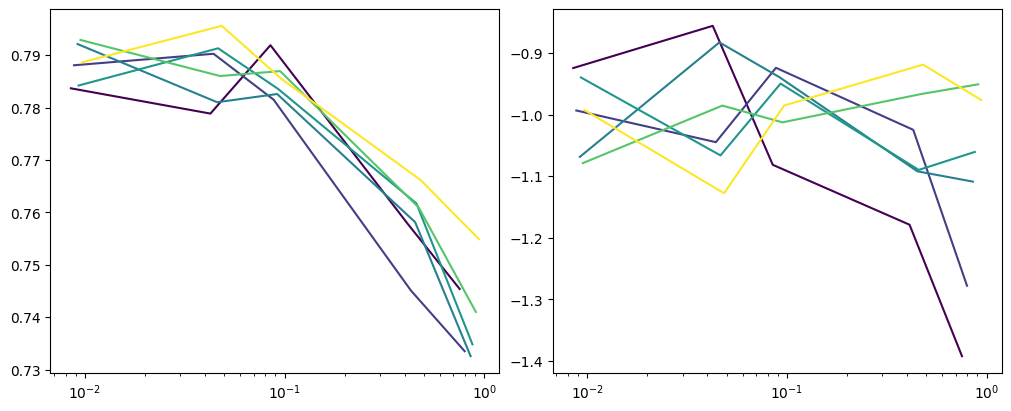

In [126]:
def my_fit_left(x, y, n_x_grids=100, xc_min=None, xc_max=None, tail_length=None, min_points=10):
    if xc_min is None:
        xc_min = x.max() * 0.9
    if xc_max is None:
        xc_max = x.max() * 1.1
    if tail_length is None:
        tail_length = x.size

    x_grid = np.linspace(xc_min, xc_max, n_x_grids)

    errors = []
    for xc in x_grid:
        delta = np.log10(xc - x)
        f = np.log10(y)
        mask = ~(np.isnan(f) | np.isnan(delta))
        if np.sum(mask) < min_points:
            sse = np.inf
        else:
            m, b = np.polyfit(delta[mask], f[mask], 1)
            sse = np.sum((m * delta[mask][:tail_length] + b - f[mask][:tail_length]) ** 2)
        errors.append(sse)

    xc = x_grid[np.argmin(errors)]
    delta = np.log10(xc - x)
    f = np.log10(y)
    mask = ~(np.isnan(f) | np.isnan(delta))
    m, b = np.polyfit(delta[mask], f[mask], 1)

    return {
        'xc': xc,
        'sse': min(errors),
        'A': 10 ** b,
        'n': m
    }

nv_norm = LogNorm(vmin=df.nv.min(), vmax=df.nv.max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

for nv in np.unique(df.nv):
    mus, xc, n = [], [], []
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]

        tau_max = 5e5
        mask = ~np.isnan(_df.tau_small) & (_df.tau_small < tau_max)
        amask = ~np.isnan(_df.atau_small) & (_df.atau_small < tau_max)

        x = _df.phi[mask].values
        y = _df.tau_small[mask].values

        # x = _df.phi[amask].values
        # y = _df.atau_small[amask].values

        tau_fit = my_fit_left(x, y, 1000, xc_min=0.98 * x.max(), xc_max=1.2 * x.max(), tail_length=10, min_points=10)
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = tau_fit['A'] * (tau_fit['xc'] - x_fit) ** tau_fit['n']
        # plt.plot(x_fit, y_fit, c=cmap(mu_norm(mu)))
        # plt.scatter(_df.phi[mask], _df.tau_small[mask], s=5, c=cmap(mu_norm(mu)))
        # plt.yscale('log')
        # plt.show()
        xc.append(tau_fit['xc'])
        n.append(tau_fit['n'])
        mus.append(mu)
        # print(tau_fit)
    
    xc = np.array(xc)
    n = np.array(n)
    mus = np.array(mus)
    ax[0].plot(mus, xc, c=cmap(nv_norm(nv)))
    ax[1].plot(mus, n, c=cmap(nv_norm(nv)))
for a in ax:
    a.set_xscale('log')
plt.show()


/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_87478/1487504196.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.r0_small, s=1, c=cmap(mu_norm(mu)))
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_87478/1487504196.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.phi, _df.r0_large, s=1, c=cmap(mu_norm(mu)))


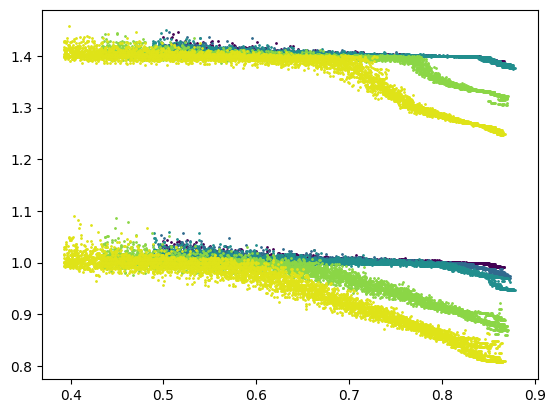

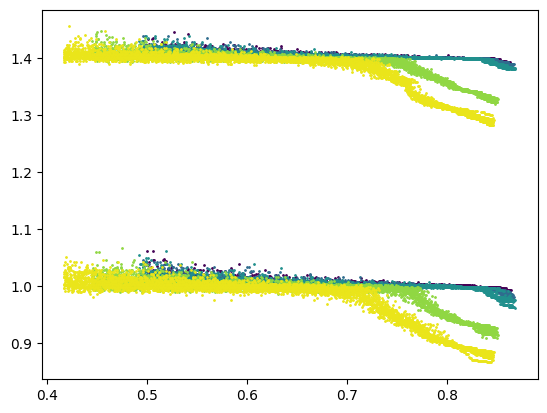

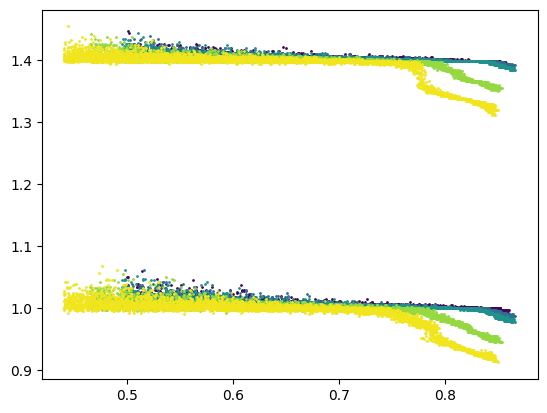

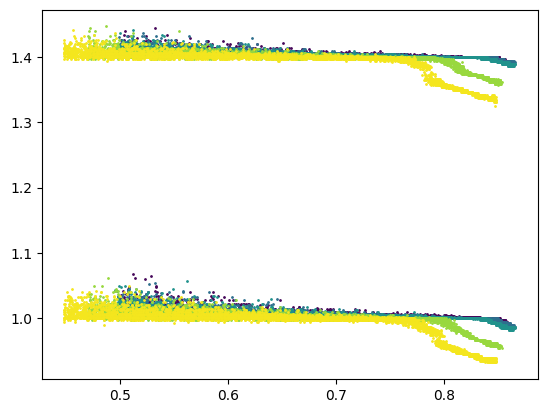

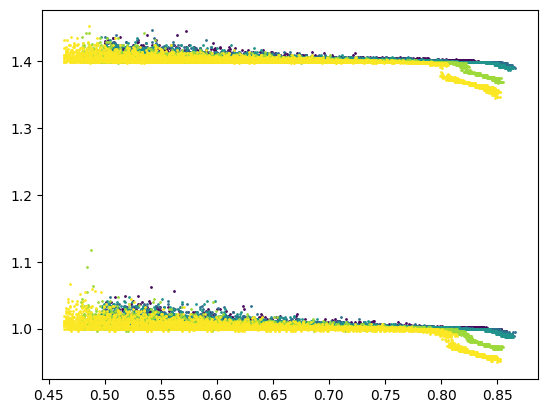

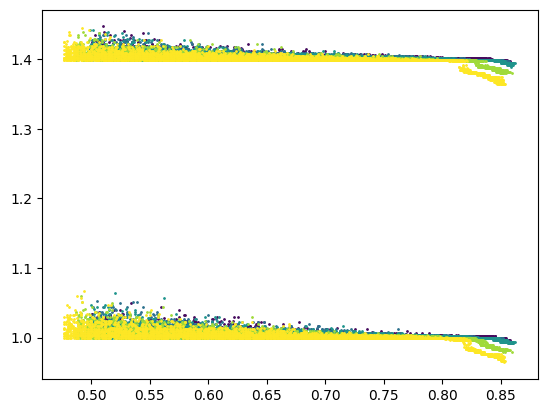

In [114]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        plt.scatter(_df.phi, _df.r0_small, s=1, c=cmap(mu_norm(mu)))
        plt.scatter(_df.phi, _df.r0_large, s=1, c=cmap(mu_norm(mu)))
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_87478/2691015261.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(_df.r0_small - _df.r0_small.values[i], _df.atau_small, s=1, c=cmap(mu_norm(mu)))


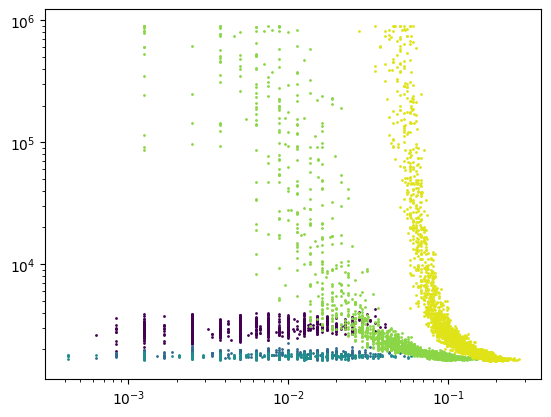

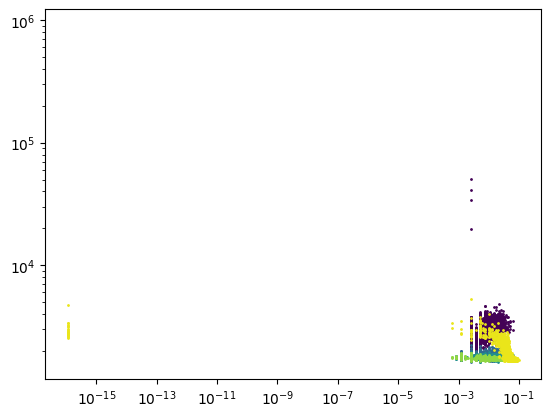

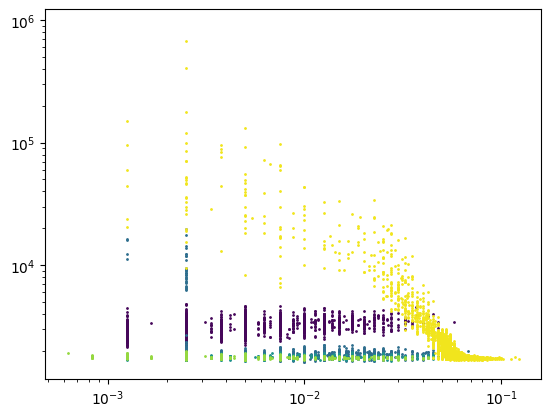

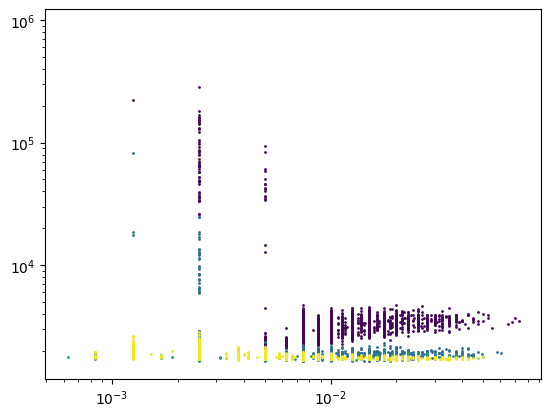

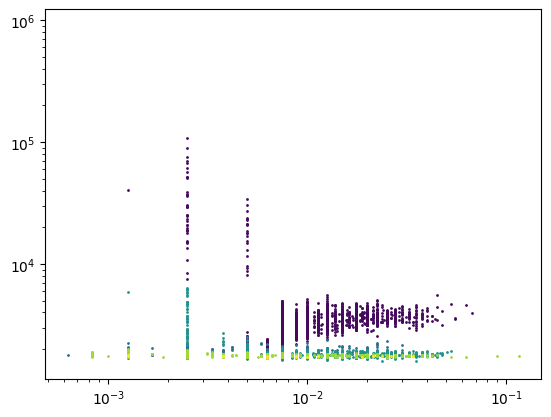

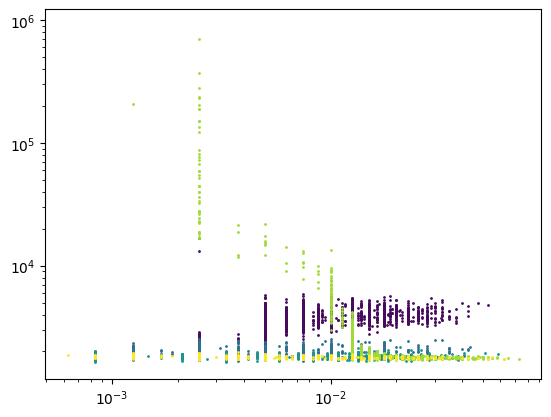

In [115]:
mu_norm = LogNorm(vmin=df.mu.min(), vmax=df.mu.max())
cmap = plt.cm.viridis

for nv in np.unique(df.nv):
    for mu in np.unique(df.mu[df.nv == nv]):
        _df = df[(df.nv == nv) & (df.mu == mu)]
        # i = _df.phi.values.argmax()
        i = _df.phi[~np.isnan(_df.atau_small)].values.argmax()
        plt.scatter(_df.r0_small - _df.r0_small.values[i], _df.atau_small, s=1, c=cmap(mu_norm(mu)))
    plt.yscale('log')
    plt.xscale('log')
    plt.show()